# ROC curves

Well, Michele said I should not use the sklearn function but do the histogram my own and also get some more intuition about them. So here is the notebook where I'm exploring this. 

In [1]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator, FuncFormatter

import gc

from sklearn.metrics import roc_curve, auc, roc_auc_score
from matplotlib.lines import Line2D

%load_ext autoreload
%autoreload 2

In [2]:
from cycler import cycler
import matplotlib

# Set the color cycle
#plt.rc('axes', prop_cycle=cycler('color', ['#73b06f', '#e6701b', '#007090', '#c7463d', '#ffad08', '#6f73b0', '#56b4e9', '#4c6e3d', '#c47ca2', '#f5f575']))
# https://coolors.co/542344-f68e5f-e5e059-007ea7-98e2c6
plt.rc('axes', prop_cycle=cycler('color', ['#73b06f', '#e6701b', '#007090', '#e7298a', '#802392', '#ffad08', '#56b4e9']))

# Configure Matplotlib to use LaTeX fonts
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"

# Set font sizes
matplotlib.rcParams.update(
    {
        "font.size": 16,  # General font size
    }
)

In [3]:
def load_data(file_name):
    file = uproot.open(file_name)
    tree = file['Events;1']
    data = tree.arrays(library="np")
    return data

In [6]:

path1 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/FCCnote/fullsimCLD240_2mio.root"
path2 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/FCCnote/fastsimCLD240_2mio.root"

data1 = load_data(path1)
data2 = load_data(path2)

In [5]:
data1.keys()

dict_keys(['recojet_isG', 'score_recojet_isG', 'recojet_isU', 'score_recojet_isU', 'recojet_isS', 'score_recojet_isS', 'recojet_isC', 'score_recojet_isC', 'recojet_isB', 'score_recojet_isB', 'recojet_isD', 'score_recojet_isD', 'recojet_isTAU', 'score_recojet_isTAU'])

In [6]:
data1["recojet_isG"]


array([False, False, False, ..., False, False, False])

In [7]:
data1["score_recojet_isG"]

array([0.00376648, 0.06886496, 0.0221283 , ..., 0.06983004, 0.00983262,
       0.04580642], dtype=float32)

In [4]:
def invalid_ind(data):
    ind = []
    labels = ['U', 'D', 'C', 'S', 'B', 'G', 'TAU']
    for l in labels: 
        true_labels = data[f'recojet_is{l}']
        scores = data[f'score_recojet_is{l}']
        valid_indices = np.where(np.isnan(scores))
        ind.append(valid_indices)
    return np.unique(ind)

In [6]:
def get_y_true_and_score(data):
    labels = ['U', 'D', 'C', 'S', 'B', 'G', 'TAU']
    y_true = np.array([data[f'recojet_is{label}'] for label in labels])
    y_true = np.argmax(y_true.T, axis=1)
    y_score = np.array([data[f'score_recojet_is{label}'] for label in labels])
    #print(y_score.shape)
    ind_nan = invalid_ind(data)
    #print(ind_nan)
    #print(ind_nan.shape)
    y_score = np.delete(y_score, ind_nan, axis=1)
    y_true = np.delete(y_true, ind_nan)
    return y_true, y_score.T

In [46]:
y_true, y_score = get_y_true_and_score(data2)

In [47]:
y_score[587102:587112, :4]

array([[0.16924901, 0.5931884 , 0.00653229, 0.10157994],
       [0.47105587, 0.4677526 , 0.00947518, 0.0346144 ],
       [0.18659401, 0.1720895 , 0.10107028, 0.50495   ],
       [0.23316793, 0.25080073, 0.0501825 , 0.4414096 ],
       [0.08216835, 0.07296664, 0.00716673, 0.0371244 ],
       [0.14777446, 0.14284569, 0.04770796, 0.02074671],
       [0.39221838, 0.40778366, 0.12607637, 0.06398536],
       [0.6913988 , 0.27419385, 0.00210346, 0.00775325],
       [0.06075188, 0.05307973, 0.00247584, 0.8680444 ],
       [0.06642318, 0.06829168, 0.02835246, 0.18687806]], dtype=float32)

In [48]:
y_score.shape

(687070, 7)

In [7]:
def change_ud_to_l(y_score, y_true=None, keep_ud=False):
    # change u and d probabilites to (u+d)/2
    if keep_ud == False:
        mean_value = np.mean(y_score[:, :2], axis=1)
        y_score[:, 0] = mean_value
        y_score[:, 1] = mean_value
    elif keep_ud==True and y_true.any()!= None: 
        i_not_u = np.where(y_true!=0)
        i_not_d = np.where(y_true!=1)
        i_not = np.intersect1d(i_not_u, i_not_d)

        mean_value = np.mean(y_score[i_not, :2], axis=1)
        y_score[i_not, 0] = mean_value
        y_score[i_not, 1] = mean_value
    else: 
        raise ValueError("pass y_true if to keep ud")
    return y_score



In [50]:
y_score_test =  change_ud_to_l(y_score, y_true, True)

(array([     0,      1,      2, ..., 587099, 587100, 587101]),)
(487134,)
687070
(487134,)


In [54]:
np.where(y_true==3)

(array([399872, 399873, 399874, ..., 499837, 499838, 499839]),)

In [55]:
y_score_test[399872:399882, :4]

array([[8.2950339e-02, 8.2950339e-02, 1.4520205e-02, 7.5898212e-01],
       [6.0104001e-02, 6.0104001e-02, 2.4714414e-02, 7.9530400e-01],
       [3.4895712e-01, 3.4895712e-01, 1.3534646e-02, 2.7002132e-01],
       [2.3037091e-01, 2.3037091e-01, 3.5802767e-02, 4.4202256e-01],
       [8.4082961e-02, 8.4082961e-02, 4.9328111e-04, 8.2732475e-01],
       [1.6650492e-01, 1.6650492e-01, 6.7741731e-03, 5.9749383e-01],
       [1.7245290e-01, 1.7245290e-01, 4.1391496e-02, 3.3313334e-01],
       [9.8481938e-02, 9.8481938e-02, 9.4722681e-02, 4.1916388e-01],
       [1.0622964e-01, 1.0622964e-01, 1.5790120e-03, 7.6209629e-01],
       [4.2936832e-02, 4.2936832e-02, 5.2964512e-02, 7.7587962e-01]],
      dtype=float32)

In [9]:
np.unique(y_true)

array([0, 1, 2, 3, 4, 5, 6])

In [8]:
y_true

array([4, 4, 4, ..., 0, 0, 0])

In [12]:
print(y_score.shape)
print(y_score[0])
print(np.sum(y_score[0]))

(687070, 7)
[1.97998525e-05 1.24459275e-05 2.33745053e-02 1.53520723e-05
 9.75511074e-01 1.06427178e-03 2.51072856e-06]
1.0


In [8]:
# from https://github.com/doloresgarcia/LOGML_2024/blob/81dfa6428bdd6e652908562474cded362d2bf5f6/src/utils/logger_wandb.py#L204 
def create_binary_rocs(positive, negative, y_true, y_score):
    mask_positive = y_true == positive
    if negative == 0 or negative == 1: # merge u and d
        mask_negative = np.logical_or(y_true == 0, y_true == 1)# is that correct???
    else:
        mask_negative = y_true == negative
    print("mask positive shape", mask_positive.shape)
    number_positive = np.sum(mask_positive)
    print("number positive", number_positive)
    number_negative = np.sum(mask_negative)

    if number_positive > 0 and number_negative > 0:
        # Create binary labels for positive and negative classes
        y_true_positive = np.ones(number_positive)
        y_true_negative = np.zeros(number_negative)
        y_true_ = np.concatenate([y_true_positive, y_true_negative]) # array like [1,1,1,...,0,0,0,0]

        # Select scores for positive and negative classes
        y_score_positive = y_score[mask_positive]
        y_score_negative = y_score[mask_negative]

        indices = np.array([negative, positive]) # [2,4]
        y_score_selected_positive = y_score_positive[:, indices] # from all MC positive scores (true MC b) take all probabilities for b and c 
        y_score_selected_negative = y_score_negative[:, indices] # from all MC netagive scores (true MC c) talke all probabilities for b and c

        # Calculate probabilities using softmax
        y_scores_pos_prob = y_score_selected_positive / np.sum(
            y_score_selected_positive, axis=1, keepdims=True
        )
        y_scores_neg_prob = y_score_selected_negative / np.sum(
            y_score_selected_negative, axis=1, keepdims=True
        )

        log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
        log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))

        # Extract the probability for the positive class
        y_prob_positiveclass = y_scores_pos_prob[:, 1] # 1, so that b is selected
        y_prob_positiveclass_neg = y_scores_neg_prob[:, 1]



        # Concatenate probabilities for positive and negative classes
        y_prob_positive = np.concatenate([y_prob_positiveclass, y_prob_positiveclass_neg])

        y_prob_positive_log = np.concatenate([log_y_scores_pos[:,1], log_y_scores_neg[:,1]])

        # Compute ROC curve and AUC score
        print("y_true_: ", y_true_, 'shape:', y_true_.shape) # ever entry that's a MC b quark
        print("y_prob_positive: ", y_prob_positive, 'shape:', y_prob_positive.shape) # how high is the probability that this is a b quark? (normed by the probabitiy for being a b and c quark?)
        fpr, tpr, thrs = roc_curve(y_true_, y_prob_positive, pos_label=1)
        auc_score = roc_auc_score(y_true_, y_prob_positive)

        return [fpr, tpr, auc_score, y_true_, y_prob_positive, y_prob_positive_log]
    else:
        return []


Let's break this function down

In [14]:
positive = 4 # b quark
negative = 3 # c quark

In [15]:
fpr, tpr, auc_score, y_tr, y_prob_pos, y_log = create_binary_rocs(positive, negative, y_true, y_score)

mask positive shape (687070,)
number positive 99968
y_true_:  [1. 1. 1. ... 0. 0. 0.] shape: (199936,)
y_prob_positive:  [9.9998426e-01 9.9996138e-01 9.8982382e-01 ... 1.1960243e-02 1.1656129e-05
 4.4774124e-03] shape: (199936,)


In [16]:
print(y_tr.shape)
print(y_prob_pos.shape)

(199936,)
(199936,)


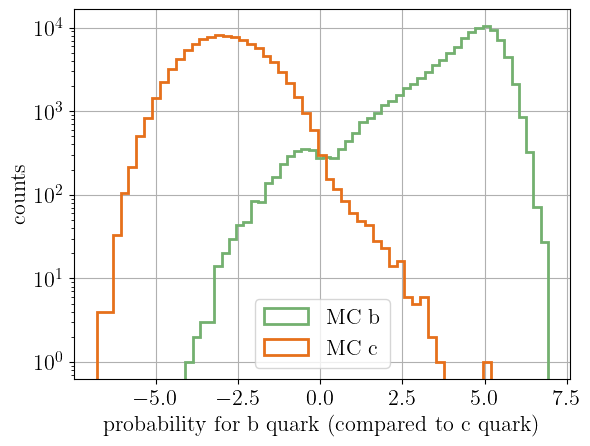

In [17]:
plt.hist(y_log[np.where(y_tr==1)], bins=50, label="MC b", histtype='step', linewidth=2.0)
plt.hist(y_log[np.where(y_tr==0)], bins=50, label="MC c", histtype='step', linewidth=2.0)
plt.legend()
plt.grid()
plt.yscale("log")
plt.ylabel("counts")
plt.xlabel("probability for b quark (compared to c quark)")
plt.show()

In [18]:
# lets use dummy thresholds of 
thrs = np.arange(0, 1, 0.01)
print(thrs)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99]


In [19]:
# b tagging efficiency is true positive rate TPR = TP/(TP + FN) = TP/ all true positive

tpr = np.sum(np.where(y_prob_pos[np.where(y_tr==1)] > 0.7)) / np.sum(np.where(y_tr==1))

In [20]:
tpr

np.float64(0.9717513613679454)

In [21]:
tpr = np.array([np.sum(np.where(y_prob_pos[np.where(y_tr==1)] > i)) / np.sum(np.where(y_tr==1)) for i in thrs])
print(tpr)

[1.         0.99796008 0.99676001 0.99573875 0.99476668 0.99403123
 0.99341062 0.99254543 0.99175083 0.99128551 0.99053617 0.98998634
 0.98941681 0.9889275  0.98840311 0.98793781 0.98744764 0.98702352
 0.98654646 0.98607417 0.98557229 0.98508635 0.98468223 0.98426571
 0.98384875 0.98348425 0.98315042 0.98277518 0.98237365 0.98208405
 0.98168197 0.9812423  0.98085948 0.98058934 0.98026734 0.98003931
 0.97970513 0.97939849 0.97917519 0.97885079 0.97855049 0.97839734
 0.97802073 0.97772812 0.97750574 0.97728214 0.97705642 0.97686465
 0.97650821 0.97634655 0.97614951 0.97592561 0.97564365 0.97552764
 0.97537934 0.97515028 0.97480751 0.97455117 0.97434559 0.974065
 0.97388573 0.97367111 0.97348592 0.97328928 0.97302741 0.97281472
 0.97261111 0.97234148 0.97215869 0.97198401 0.97175136 0.97141964
 0.97118105 0.97094368 0.97055944 0.97019079 0.96979368 0.96949646
 0.9691618  0.96885906 0.96838239 0.96793798 0.96753538 0.96701879
 0.96653717 0.96595362 0.96527012 0.96469732 0.96402279 0.963082

In [22]:
# jet misidentification probability (false positive rate) in logarithmic scale
# FPR = FP/ (FP +TN) = FP / all true negative

fpr = np.array([np.sum(np.where(y_prob_pos[np.where(y_tr==0)] > i)) / np.sum(np.where(y_tr==0)) for i in thrs])
print(fpr)


[3.33331110e-01 7.70833534e-02 5.37334966e-02 4.25273811e-02
 3.54243675e-02 3.02196982e-02 2.64732843e-02 2.35242366e-02
 2.11805050e-02 1.92295252e-02 1.77242546e-02 1.62995380e-02
 1.50425171e-02 1.38851995e-02 1.29220060e-02 1.21428513e-02
 1.13750192e-02 1.07271955e-02 1.00991234e-02 9.51435839e-03
 8.93933165e-03 8.54421276e-03 8.06906927e-03 7.63665739e-03
 7.27713194e-03 6.91608723e-03 6.59259042e-03 6.29405139e-03
 6.02009077e-03 5.76476320e-03 5.56195288e-03 5.33366978e-03
 5.13706405e-03 4.94357712e-03 4.76550745e-03 4.57039561e-03
 4.39227931e-03 4.22863198e-03 4.06226944e-03 3.92156387e-03
 3.78010514e-03 3.63302240e-03 3.50665872e-03 3.39323783e-03
 3.28958182e-03 3.15961623e-03 3.04484847e-03 2.93237359e-03
 2.84568756e-03 2.76599657e-03 2.68355514e-03 2.62323421e-03
 2.55127999e-03 2.50657510e-03 2.43763303e-03 2.38073876e-03
 2.30970474e-03 2.22111549e-03 2.15396516e-03 2.10877349e-03
 2.04847784e-03 1.99194808e-03 1.93022358e-03 1.90758375e-03
 1.87035107e-03 1.812421

<function matplotlib.pyplot.show(close=None, block=None)>

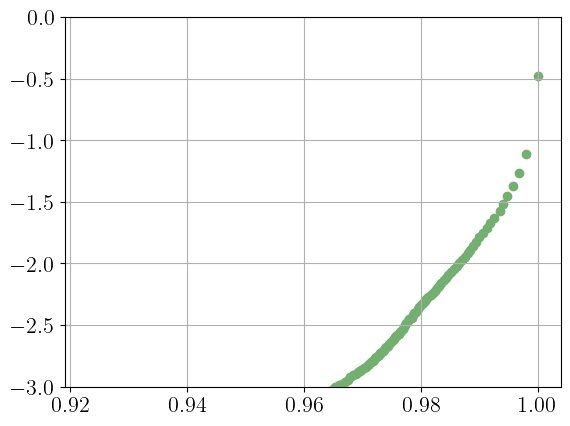

In [23]:
# add last bin like in https://github.com/scikit-learn/scikit-learn/blob/6e9039160/sklearn/metrics/_ranking.py#L1168C5-L1169C24 ?

plt.scatter(tpr, np.log10(fpr+ 1e-8))
plt.grid()
plt.ylim(-3,0)
plt.show

In [24]:
np.r_[0, np.array([1,2,3])]

array([0, 1, 2, 3])

# non-binary discriminant plots

Should look like [this](https://indico.cern.ch/event/1441581/attachments/2956375/5198535/ESchopf_241029_LHCSeminar_Htbc.pdf)

In [9]:
def change_ud_to_l(y_score, y_true=None, keep_ud=False):
    # change u and d probabilites to (u+d)/2
    if keep_ud == False:
        mean_value = np.mean(y_score[:, :2], axis=1)
        print(mean_value.shape)
        y_score[:, 0] = mean_value
        y_score[:, 1] = mean_value
    elif keep_ud==True and y_true.any()!= None: 
        i_not_u = np.where(y_true!=0)
        i_not_d = np.where(y_true!=1)
        i_not = np.intersect1d(i_not_u, i_not_d)

        mean_value = np.mean(y_score[i_not, :2], axis=1)
        y_score[i_not, 0] = mean_value
        y_score[i_not, 1] = mean_value
    else: 
        raise ValueError("pass y_true if to keep ud")
    return y_score



In [10]:
def create_label_mapping():
    labels = ['ud', 'l', 'c', 's', 'b', 'g', 'tau'] # 0 and 1 are both light (l) but function needs to bijective
    
    # Map label to integer
    label_to_int = {label: idx for idx, label in enumerate(labels)}
    
    # Map integer to label
    int_to_label = {idx: label for idx, label in enumerate(labels)}
    
    return label_to_int, int_to_label

# Example usage
label_to_int, int_to_label = create_label_mapping()

In [11]:
dic_non_bi = {"b": ["c", "b", "g"], "c": ["c", "b", "g"], "s": ["ud", "g", "s"], "g": ["ud", "b", "g"], "ud": ["ud", "l", "g", "s"], "tau": ["tau", "ud"]}

In [12]:
def non_binary_b(data1, data2, dic, label1, label2, dicx=None, lax=0):
    fig, ax = plt.subplots(2, 3, figsize=(12, 7), constrained_layout=True)
    ax = ax.flat

    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {0: color_cycle[0], 1: color_cycle[5], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2], 6: color_cycle[6]}
    ls = ["solid", "dashed"]
    
    for d, data in enumerate([data1, data2]):
        y_true, y_score = get_y_true_and_score(data)
        y_score = change_ud_to_l(y_score, y_true, True) # average ud to light

        for a, quark in enumerate(dic.keys()): # what tagging? b?
            # plot
            int_quark = label_to_int[quark]
            y_score_MC_b = y_score[np.where(y_true==int_quark)] # shape (x, 7)
            q_int = [label_to_int[q] for q in dic[quark]]

            for l, i in enumerate(q_int): # vs which quarks?
                score = y_score_MC_b[:, i]
                lab = None
                r = None
                hist_val = np.log10(score/(1 - score))
                if dicx:
                    r = dicx[quark]
                    if r:
                        hist_val = np.clip(hist_val, *r)
                if d==0:
                    lab = dic[quark][l]
                    if quark=="ud" and lab=="ud":
                        lab="u"
                    elif quark=="ud" and lab=="l":
                        lab = "d"
                ax[a].hist(hist_val, histtype='step', linewidth=2.0, density=True, bins=60, label=lab, color=dic_c[i], linestyle=ls[d], range=r)
                ax[a].grid(True)
                ax[a].legend()
                ax[a].set_xlabel(r"${}$-jet discriminant".format(quark))
                if quark=="tau":
                    ax[a].set_xlabel(r"$\tau$-jet discriminant")
                elif quark=="ud":
                    ax[a].set_xlabel(r"$u$-jet discriminant")

    # legends ...
    handles_colorful, labels_colorful = ax[lax].get_legend_handles_labels()
    legend_colorful = ax[lax].legend(handles=handles_colorful) #, title=f"{labels[4]}-tagging", title_fontproperties={'weight':'bold'})
    # Create black lines for FullSim and FastSim
    fullsim_line = Line2D([0], [0], color='black', linestyle='-', label=label1)
    fastsim_line = Line2D([0], [0], color='black', linestyle='--', label=label2)
    # Add the second legend for FullSim and FastSim
    legend_sim = ax[lax].legend(handles=[fullsim_line, fastsim_line], loc="upper left")#, bbox_to_anchor=(0.6, 1.0))
    # reset colorful legend
    ax[lax].add_artist(legend_colorful)
    
    plt.show()
        

In [133]:
path1 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/FCCnote/fullsimCLD240_tcmatch_2mio.root"
path2 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/FCCnote/fastsimCLD240_2mio.root"

data1 = load_data(path1)
data2 = load_data(path2)

In [134]:
dic_xlim = {"b": None, "c": [-6, 4], "s": [-3.5, 2], "g": [-5, 2], "ud": [-3, 1], "tau": [-10,10]}

(array([     0,      1,      2, ..., 597526, 597527, 597528]),)
(497931,)
697328
(497931,)
(array([     0,      1,      2, ..., 587099, 587100, 587101]),)
(487134,)
687070
(487134,)


/tmp/saaumill/ipykernel_2486536/2778772357.py:23: RuntimeWarning: divide by zero encountered in divide
  hist_val = np.log10(score/(1 - score))


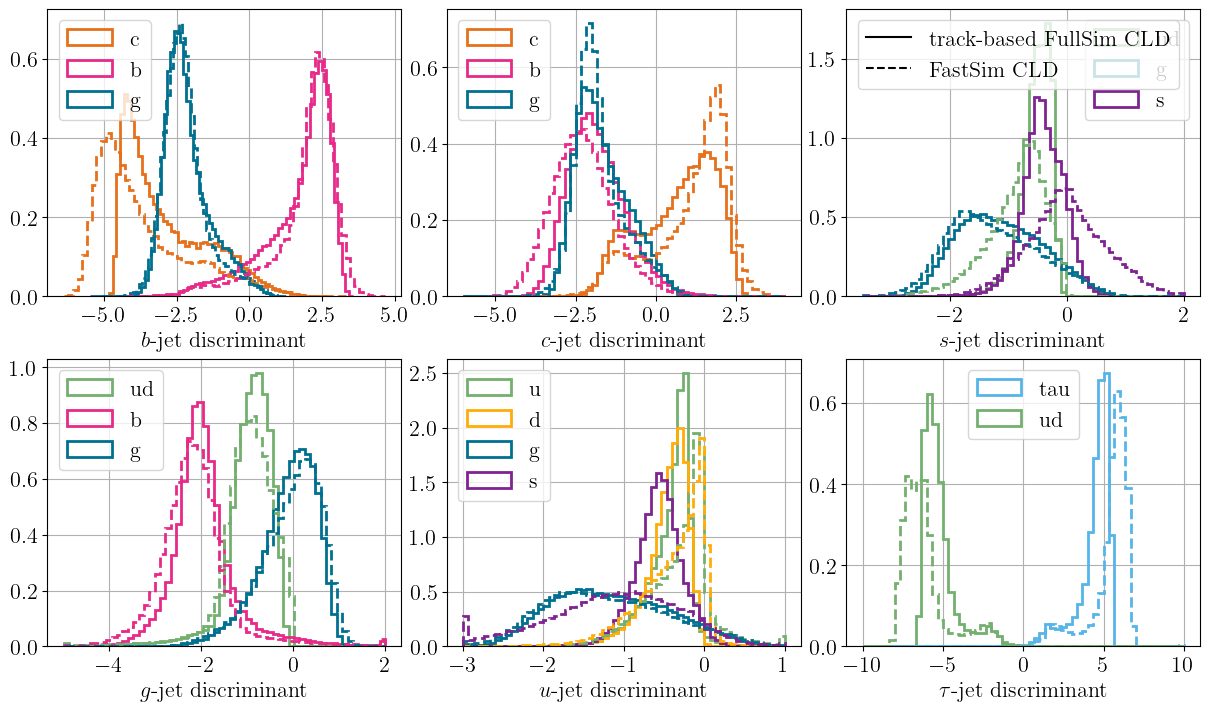

In [135]:
non_binary_b(data1, data2, dic_non_bi, "track-based FullSim CLD", "FastSim CLD", dic_xlim, lax=2)

# For the final plotting

In [21]:
# from https://github.com/doloresgarcia/LOGML_2024/blob/81dfa6428bdd6e652908562474cded362d2bf5f6/src/utils/logger_wandb.py#L204 
def create_binary_rocs(positive, negative, y_true, y_score):
    mask_positive = y_true == positive
    if negative == 0 or negative == 1: # merge u and d
        mask_negative = np.logical_or(y_true == 0, y_true == 1)# is that correct???
    else:
        mask_negative = y_true == negative
    #print("mask positive shape", mask_positive.shape)
    number_positive = np.sum(mask_positive)
    #print("number positive", number_positive)
    number_negative = np.sum(mask_negative)

    if number_positive > 0 and number_negative > 0:
        # Create binary labels for positive and negative classes
        y_true_positive = np.ones(number_positive)
        y_true_negative = np.zeros(number_negative)
        y_true_ = np.concatenate([y_true_positive, y_true_negative]) # array like [1,1,1,...,0,0,0,0]

        # Select scores for positive and negative classes
        y_score_positive = y_score[mask_positive]
        y_score_negative = y_score[mask_negative]

        indices = np.array([negative, positive]) # [2,4]
        y_score_selected_positive = y_score_positive[:, indices] # from all MC positive scores (true MC b) take all probabilities for b and c 
        y_score_selected_negative = y_score_negative[:, indices] # from all MC netagive scores (true MC c) talke all probabilities for b and c

        # Calculate probabilities to get binary!!
        y_scores_pos_prob = y_score_selected_positive / np.sum(
            y_score_selected_positive, axis=1, keepdims=True
        )
        y_scores_neg_prob = y_score_selected_negative / np.sum(
            y_score_selected_negative, axis=1, keepdims=True
        )

        log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
        log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))

        # Extract the probability for the positive class
        y_prob_positiveclass = y_scores_pos_prob[:, 1] # 1, so that b is selected
        y_prob_positiveclass_neg = y_scores_neg_prob[:, 1]



        # Concatenate probabilities for positive and negative classes
        y_prob_positive = np.concatenate([y_prob_positiveclass, y_prob_positiveclass_neg])

        y_prob_positive_log = np.concatenate([log_y_scores_pos[:,1], log_y_scores_neg[:,1]])

        # Compute ROC curve and AUC score
        #print("y_true_: ", y_true_, 'shape:', y_true_.shape) # ever entry that's a MC b quark
        #print("y_prob_positive: ", y_prob_positive, 'shape:', y_prob_positive.shape) # how high is the probability that this is a b quark? (normed by the probabitiy for being a b and c quark?)
        fpr, tpr, thrs = roc_curve(y_true_, y_prob_positive_log, pos_label=1)
        auc_score = roc_auc_score(y_true_, y_prob_positive_log)

        return [fpr, tpr, auc_score]#, y_true_, y_prob_positive, y_prob_positive_log]
    else:
        return []


In [35]:
def log_multiline_rocs_b(y_true, y_score, labels, ax, k,j, ls="solid", l=True):
    q_tag = 4 # b-tagging
    vs_tag = [1,2, 5] # g, u, c
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score)


    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0:
        # Calculate TPR for different ROC curves (this function needs to be defined elsewhere)
        #calculate_and_log_tpr_1_10_percent(_bg[0], _bg[1], "b", "g")
        #calculate_and_log_tpr_1_10_percent(_bud[0], _bud[1], "b", "ud")
        #calculate_and_log_tpr_1_10_percent(_bc[0], _bc[1], "b", "c")

        # Plot ROC curves
        xs = [_bg[1], _bud[1], _bc[1]]
        ys = [_bg[0], _bud[0], _bc[0]]
        auc_ = [_bg[2], _bud[2], _bc[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            if l:
                label = f"{labels[q_tag]} vs {labels[vs_tag[i]]}"
            else:
                label=None
            ax[k, j].plot(x, y, label=label, color=dic_c[vs_tag[i]], linestyle=ls) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k,j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k,j].grid()
        ax[k,j].set_ylim(-3, 0)
        ax[k,j].set_xlabel("jet tagging efficiency")
        ax[k,j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")


def log_multiline_rocs_c(y_true, y_score, labels, ax, k, j, ls="solid", l=True):
    q_tag = 2 # b-tagging
    vs_tag = [1,4, 5] # ud, b, g
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score)

    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0:
        xs = [_bg[1], _bud[1], _bc[1]]
        ys = [_bg[0], _bud[0], _bc[0]]
        auc_ = [_bg[2], _bud[2], _bc[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            if l:
                label = f"{labels[q_tag]} vs {labels[vs_tag[i]]}"
            else:
                label=None
            ax[k, j].plot(x, y, label=label, color=dic_c[vs_tag[i]], linestyle=ls) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k, j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k, j].grid()
        ax[k, j].set_ylim(-3, 0)
        ax[k, j].set_xlabel("jet tagging efficiency")
        ax[k, j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")

def log_multiline_rocs_s(y_true, y_score, labels, ax, k, j, ls="solid", l=True):
    q_tag = 3 # s-tagging
    vs_tag = [1,2, 4, 5] # ud, b, g
    # colors 
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score)
    _bs = create_binary_rocs(q_tag, vs_tag[3], y_true, y_score)

    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0 and len(_bs) > 0:
        xs = [_bg[1], _bud[1], _bc[1], _bs[1]]
        ys = [_bg[0], _bud[0], _bc[0], _bs[0]]
        auc_ = [_bg[2], _bud[2], _bc[2], _bs[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            if l:
                label = f"{labels[q_tag]} vs {labels[vs_tag[i]]}"
            else:
                label=None
            ax[k, j].plot(x, y, label=label, color=dic_c[vs_tag[i]], linestyle=ls) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k, j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k, j].grid()
        ax[k, j].set_ylim(-3, 0)
        ax[k, j].set_xlabel("jet tagging efficiency")
        ax[k, j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")


def log_multiline_rocs_g(y_true, y_score, labels, ax, k, j, ls="solid", l=True):
    q_tag = 5 # g-tagging
    vs_tag = [1,2, 3, 4] # ud, b, g
    # colors 
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score)
    _bs = create_binary_rocs(q_tag, vs_tag[3], y_true, y_score)

    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0 and len(_bs) > 0:
        xs = [_bg[1], _bud[1], _bc[1], _bs[1]]
        ys = [_bg[0], _bud[0], _bc[0], _bs[0]]
        auc_ = [_bg[2], _bud[2], _bc[2], _bs[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            if l:
                label = f"{labels[q_tag]} vs {labels[vs_tag[i]]}"
            else:
                label=None
            ax[k, j].plot(x, y, label=label, color=dic_c[vs_tag[i]], linestyle=ls) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k, j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k, j].grid()
        ax[k, j].set_ylim(-3, 0)
        ax[k, j].set_xlabel("jet tagging efficiency")
        ax[k, j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")

In [36]:
def all_rocs(label1, label2, save=False, name=None):
    labels = ['ud', 'ud', 'c', 's', 'b', 'g', 'tau']
    fig, ax = plt.subplots(2, 2, figsize=(12, 7), constrained_layout=True)
    y_true, y_score = get_y_true_and_score(data1)


    # Plot ROC curves for tagging
    log_multiline_rocs_b(y_true, y_score, labels, ax, 0, 0)
    log_multiline_rocs_c(y_true, y_score, labels, ax, 0, 1)
    log_multiline_rocs_s(y_true, y_score, labels, ax, 1, 0)
    log_multiline_rocs_g(y_true, y_score, labels, ax, 1, 1)

    y_true, y_score = get_y_true_and_score(data2)

    # Plot ROC curves for tagging
    log_multiline_rocs_b(y_true, y_score, labels, ax, 0, 0, ls="dashed", l=False)
    log_multiline_rocs_c(y_true, y_score, labels, ax, 0, 1, ls="dashed", l=False)
    log_multiline_rocs_s(y_true, y_score, labels, ax, 1, 0, ls="dashed", l=False)
    log_multiline_rocs_g(y_true, y_score, labels, ax, 1, 1, ls="dashed", l=False)


    # Create the first legend for colorful ROC curves
    handles_colorful, labels_colorful = ax[0,0].get_legend_handles_labels()
    legend_colorful = ax[0,0].legend(handles=handles_colorful, title=f"{labels[4]}-tagging", title_fontproperties={'weight':'bold'})

    # Create black lines for FullSim and FastSim
    fullsim_line = Line2D([0], [0], color='black', linestyle='-', label=label1)
    fastsim_line = Line2D([0], [0], color='black', linestyle='--', label=label2)

    # Add the second legend for FullSim and FastSim
    legend_sim = ax[0,0].legend(handles=[fullsim_line, fastsim_line], loc="upper center", bbox_to_anchor=(0.6, 1.0))

    # Add back the first legend (colorful ROC curves) to the plot
    ax[0,0].add_artist(legend_colorful)
    # Re-enable the grid for all subplots
    for row in range(2):
        for col in range(2):
            ax[row, col].grid(True)  # Make sure the grid is visible
    
    if save:
        plt.savefig("./plots-for-FCC-note/{}.pdf".format(name))
    plt.show()

In [37]:

#path1 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/FCCnote/fullsimCLD240_2mio.root"
path2 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/FCCnote/fastsimCLD240_2mio.root"
path1 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/FCCnote/fullsimCLD240_tcmatch_2mio.root"

data1 = load_data(path1)
data2 = load_data(path2)

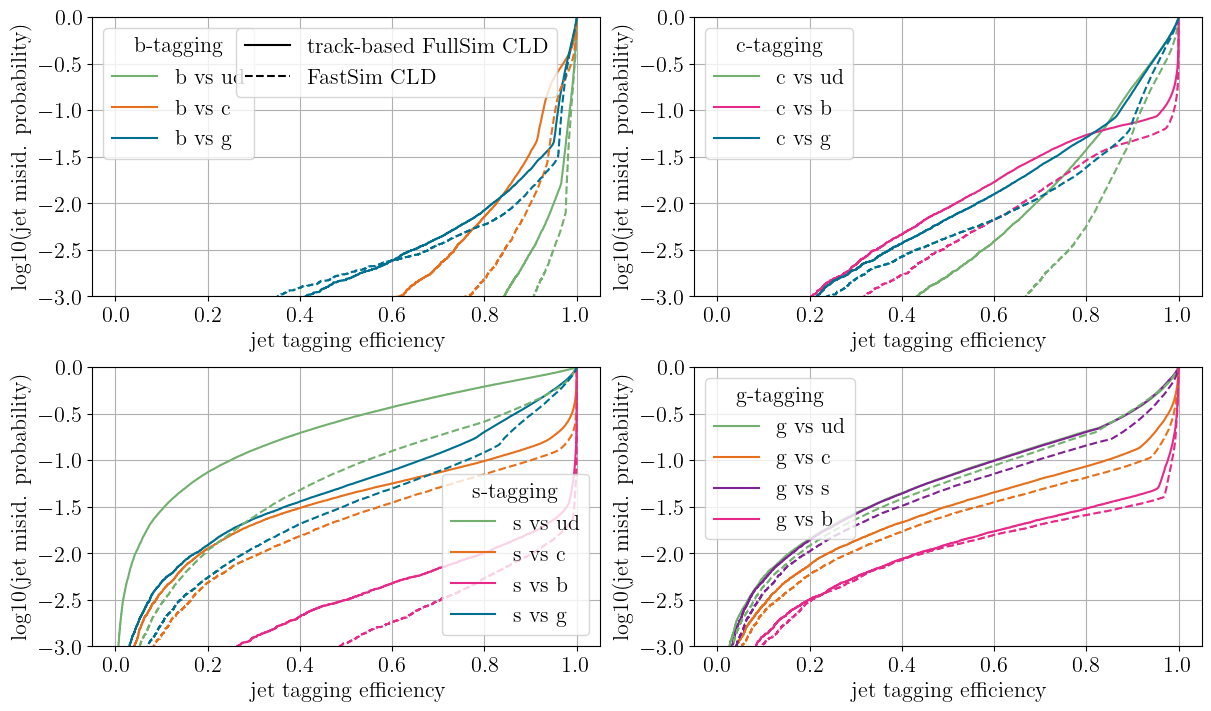

In [38]:
all_rocs('track-based FullSim CLD', 'FastSim CLD', save=False)

## Create binary plot with e.g. "b" "c" as input to then just create the roc curve...

In [35]:

path1 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/FCCnote/fullsimCLD240_2mio.root"
path2 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/FCCnote/fullsimCLD240_Vs_2mio.root"

data1 = load_data(path1)
data2 = load_data(path2)

In [94]:
def rocs(label1, label2, list_q, save=False, name=None, loc="upper left", bb=(0, 1.0)):
    labels = ['ud', 'ud', 'c', 's', 'b', 'g', 'tau']
    fig, ax = plt.subplots(1, 1, figsize=(5, 4.5), constrained_layout=True)

    linestyles = ["solid", "dashed"]
    lab = [True, False]
    for i, d in enumerate([data1, data2]):
        y_true, y_score = get_y_true_and_score(d)
        y_score = change_ud_to_l(y_score, y_true, True)

        # Plot ROC curves for tagging
        for quarks in list_q:
            log_multiline_rocs(y_true, y_score, quarks[0], quarks[1], ax, ls=linestyles[i], l=lab[i])


    # Create the first legend for colorful ROC curves
    handles_colorful, labels_colorful = ax.get_legend_handles_labels()
    legend_colorful = ax.legend(handles=handles_colorful)

    ## Create black lines for FullSim and FastSim
    fullsim_line = Line2D([0], [0], color='black', linestyle='-', label=label1)
    fastsim_line = Line2D([0], [0], color='black', linestyle='--', label=label2)

    ## Add the second legend for FullSim and FastSim
    legend_sim = ax.legend(handles=[fullsim_line, fastsim_line], loc=loc, bbox_to_anchor=bb)

    ## Add back the first legend (colorful ROC curves) to the plot
    ax.add_artist(legend_colorful)
    ax.grid(True)
    
    if save:
        plt.savefig("./plots-for-FCC-note/{}.pdf".format(name))
    plt.show()

In [85]:
transl_to_i = {"l": 0, "u": 0, "d":1, "ud": 0, 'c':2, 's':3, 'b':4, 'g':5, 'tau':6}

In [86]:
# from https://github.com/doloresgarcia/LOGML_2024/blob/81dfa6428bdd6e652908562474cded362d2bf5f6/src/utils/logger_wandb.py#L204 
def create_binary_rocs(positive, negative, y_true, y_score):
    mask_positive = y_true == positive
    if negative == 0 or negative == 1: # merge u and d
        mask_negative = np.logical_or(y_true == 0, y_true == 1)# is that correct???
    else:
        mask_negative = y_true == negative
    #print("mask positive shape", mask_positive.shape)
    number_positive = np.sum(mask_positive)
    #print("number positive", number_positive)
    number_negative = np.sum(mask_negative)

    if number_positive > 0 and number_negative > 0:
        # Create binary labels for positive and negative classes
        y_true_positive = np.ones(number_positive)
        y_true_negative = np.zeros(number_negative)
        y_true_ = np.concatenate([y_true_positive, y_true_negative]) # array like [1,1,1,...,0,0,0,0]

        # Select scores for positive and negative classes
        y_score_positive = y_score[mask_positive]
        y_score_negative = y_score[mask_negative]

        indices = np.array([negative, positive]) # [2,4]
        y_score_selected_positive = y_score_positive[:, indices] # from all MC positive scores (true MC b) take all probabilities for b and c 
        y_score_selected_negative = y_score_negative[:, indices] # from all MC netagive scores (true MC c) talke all probabilities for b and c

        # Calculate probabilities to get binary!!
        y_scores_pos_prob = y_score_selected_positive / np.sum(
            y_score_selected_positive, axis=1, keepdims=True
        )
        y_scores_neg_prob = y_score_selected_negative / np.sum(
            y_score_selected_negative, axis=1, keepdims=True
        )

        log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
        log_y_scores_neg = np.log10(y_scores_neg_prob/(1-y_scores_neg_prob))

        # Extract the probability for the positive class
        y_prob_positiveclass = y_scores_pos_prob[:, 1] # 1, so that b is selected
        y_prob_positiveclass_neg = y_scores_neg_prob[:, 1]

        i_int = [3,5,6]
        #print(y_score_selected_positive[i_int])
        #print(y_scores_pos_prob[i_int])
        #print(log_y_scores_pos[i_int])

        # Concatenate probabilities for positive and negative classes
        y_prob_positive = np.concatenate([y_prob_positiveclass, y_prob_positiveclass_neg])

        y_prob_positive_log = np.concatenate([log_y_scores_pos[:,1], log_y_scores_neg[:,1]])

        # Compute ROC curve and AUC score
        #print("y_true_: ", y_true_, 'shape:', y_true_.shape) # ever entry that's a MC b quark
        #print("y_prob_positive: ", y_prob_positive, 'shape:', y_prob_positive.shape) # how high is the probability that this is a b quark? (normed by the probabitiy for being a b and c quark?)
        #print("-------", positive, negative, "------")
        if np.isnan(y_prob_positive_log).any() or np.isinf(y_prob_positive_log).any():
            print("Data contains NaN or inf values.")
        invalid_indices = np.where(np.isnan(y_prob_positive_log) | np.isinf(y_prob_positive_log))
        #print("invalid ind", invalid_indices)
        #print("shape", len(invalid_indices[0]))
        #fpr, tpr, thrs = roc_curve(y_true_[~invalid_indices], y_prob_positive_log[~invalid_indices], pos_label=1)
        #auc_score = roc_auc_score(y_true_[~invalid_indices], y_prob_positive_log[~invalid_indices])
        try:
            fpr, tpr, thrs = roc_curve(y_true_, y_prob_positive_log, pos_label=1)
            auc_score = roc_auc_score(y_true_, y_prob_positive_log)
        except: 
            fpr, tpr, thrs = roc_curve(y_true_, y_prob_positive, pos_label=1)
            auc_score = roc_auc_score(y_true_, y_prob_positive)

        return [fpr, tpr, auc_score]#, y_true_, y_prob_positive, y_prob_positive_log]
    else:
        return []


In [97]:
def log_multiline_rocs(y_true, y_score, q1, q2, ax, ls="solid", l=True):
    q_tag = transl_to_i[q1] # 4: b-tagging
    vs_tag = transl_to_i[q2] # g, u, c
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {0: color_cycle[0], 1: color_cycle[5], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2], 6: color_cycle[6]}
    y, x, auc = create_binary_rocs(q_tag, vs_tag, y_true, y_score)

    # plot
    ys_log = [np.log10(j + 1e-8) for j in y] 
    if l:
        qu1 = q1
        if q1 == "tau":
            qu1 = r"$\tau$"
        label = f"{qu1} vs {q2}"
    else:
        label=None
    ax.plot(x, ys_log, label=label, color=dic_c[vs_tag], linestyle=ls) #(AUC={auc_[i]:.3f})")
    ax.grid(True)
    ax.set_ylim(-3, 0)
    if q1=="tau":
        ax.set_xlim(0.95, 1.01)
        ax.set_ylim(-5, 0)
    ax.set_xlabel("jet tagging efficiency")
    ax.set_ylabel("log10(jet misid. probability)")

In [78]:

path1 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/FCCnote/fullsimCLD240_tcmatch_2mio.root"
path2 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/FCCnote/fastsimCLD240_noPID_2mio.root"

data1 = load_data(path1)
data2 = load_data(path2)

In [101]:
save_status = False

/tmp/ipykernel_2654905/1880705159.py:35: RuntimeWarning: divide by zero encountered in divide
  log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))
/tmp/ipykernel_2654905/1880705159.py:35: RuntimeWarning: divide by zero encountered in divide
  log_y_scores_pos = np.log10(y_scores_pos_prob/(1-y_scores_pos_prob))


Data contains NaN or inf values.
Data contains NaN or inf values.


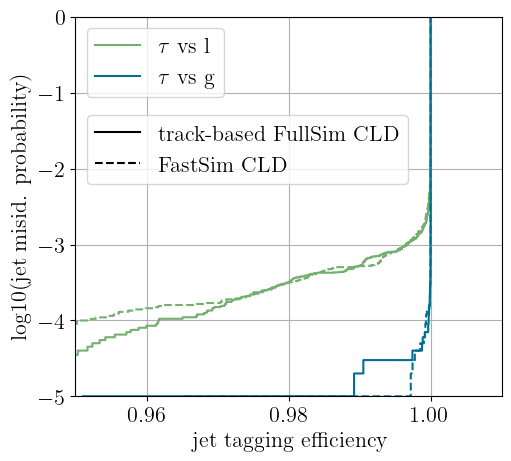

In [102]:
list_q = [["tau", "l"], ["tau", "g"]]
rocs("track-based FullSim CLD", "FastSim CLD", list_q, loc="center left", bb=(0, 0.65), save=save_status, name="roc-CLD-fast-vs-fulltc_tau")

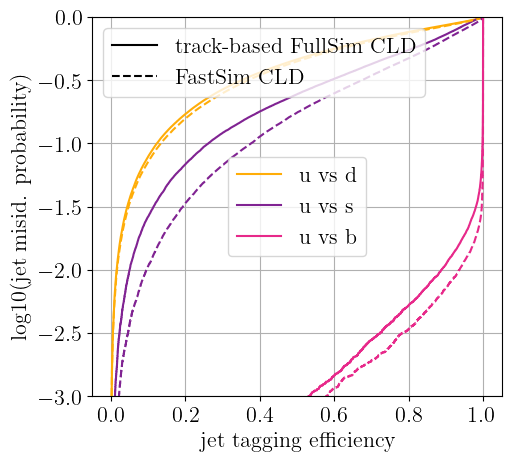

In [104]:
list_q = [["u", "d"], ["u", "s"], ["u", "b"]]
rocs("track-based FullSim CLD", "FastSim CLD", list_q, save=save_status, name="roc-CLD-fast-vs-fulltc_u")

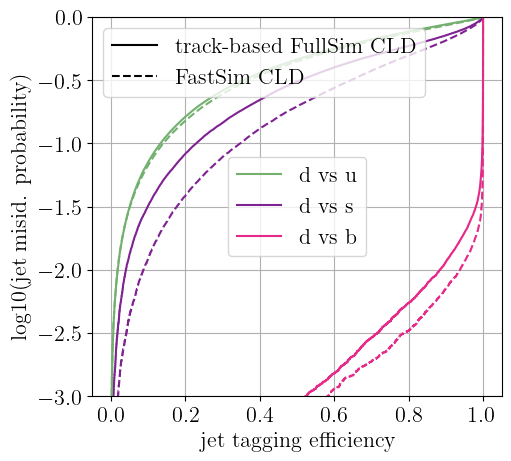

In [105]:
list_q = [["d", "u"], ["d", "s"], ["d", "b"]]
rocs("track-based FullSim CLD", "FastSim CLD", list_q, save=save_status, name="roc-CLD-fast-vs-fulltc_d")